In [1]:
# Install required packages
!pip install transformers 
!pip install datasets 
!pip install tensorflow 
!pip install pandas 
!pip install numpy 
!pip install scikit-learn 
!pip install matplotlib 
!pip install seaborn 
!pip install tqdm tf-keras

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

from transformers import (
    TFDistilBertModel,
    DistilBertTokenizer,
    TFDistilBertForSequenceClassification,
    DistilBertConfig
)

import tensorflow as tf
from datasets import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [3]:
def preprocess_text(text):
    """Enhanced preprocessing for complex linguistic features"""


    # Contraction map
    contraction_map = {
        "can't": "cannot",
        "won't": "will not",
        "n't": " not",
        "'re": " are",
        "'s": " is",
        "'d": " would",
        "'ll": " will",
        "'ve": " have",
        "'m": " am",
        "it's": "it is",
        "let's": "let us",
        "who's": "who is",
        "what's": "what is",
        "there's": "there is",
        "we're": "we are",
        "they're": "they are",
        "you're": "you are",
        "he's": "he is",
        "she's": "she is",
        "isn't": "is not",
        "aren't": "are not",
        "wasn't": "was not",
        "weren't": "were not",
        "hasn't": "has not",
        "haven't": "have not",
        "doesn't": "does not",
        "don't": "do not",
        "didn't": "did not",
        "shouldn't": "should not",
        "wouldn't": "would not",
        "couldn't": "could not",
        "mightn't": "might not",
        "mustn't": "must not",
    }

    # Expand contractions
    for contraction, expanded in contraction_map.items():
        text = text.replace(contraction, expanded)

    
    # Preserve special tokens that might indicate sarcasm or sentiment
    special_tokens = {
        '!!!': ' MULTI_EXCLAIM ',
        '...': ' ELLIPSIS ',
        '??': ' MULTI_QUESTION ',
        ':)': ' HAPPY_EMOJI ',
        ':(': ' SAD_EMOJI ',
        ':/': ' SKEPTICAL_EMOJI '
    }

    for token, replacement in special_tokens.items():
        text = text.replace(token, replacement)

    # Preserve negation contexts
    negation_words = ['not', 'never', "n't", 'no', 'neither', 'nor']
    for word in negation_words:
        text = text.replace(f'{word} ', f'{word}_NEG ')

    # Mark potential sarcasm indicators
    sarcasm_markers = ['obviously', 'clearly', 'surely', 'right', 'sure']
    for marker in sarcasm_markers:
        text = text.replace(f'{marker} ', f'{marker}_SARC ')

    return text

In [4]:
class EnhancedDistilBertForSentiment(tf.keras.Model):
    def __init__(self, num_classes=3):
        super().__init__()
        
        # Load DistilBERT
        self.distilbert = TFDistilBertModel.from_pretrained('distilbert-base-uncased')
        
        # Adjusted LSTM units based on average text length
        lstm_units = 156  # Slightly larger than average word count
        
        # Bidirectional LSTM with adjusted units
        self.lstm = tf.keras.layers.Bidirectional(
            tf.keras.layers.LSTM(lstm_units, return_sequences=True)
        )
        
        # Updated attention dimensions
        attention_dim = 96  # Increased for better feature capture
        self.attention_query = tf.keras.layers.Dense(attention_dim)
        self.attention_key = tf.keras.layers.Dense(attention_dim)
        self.attention_value = tf.keras.layers.Dense(attention_dim)
        
        # Adjusted fusion layers
        self.fusion_dense1 = tf.keras.layers.Dense(320, activation='relu')  # Increased width
        self.fusion_dense2 = tf.keras.layers.Dense(160, activation='relu')
        
        # Adjusted dropout rate based on text length variability
        self.dropout1 = tf.keras.layers.Dropout(0.25)  # Before fusion
        self.dropout2 = tf.keras.layers.Dropout(0.35)  # After fusion
        
        # Output layer
        self.classifier = tf.keras.layers.Dense(num_classes, activation='softmax')

    def attention(self, query, key, value, training=False):
        attention_weights = tf.matmul(query, key, transpose_b=True)
        attention_weights = tf.nn.softmax(attention_weights, axis=-1)
        attended_values = tf.matmul(attention_weights, value)
        return attended_values

    def call(self, inputs, training=False):
        # Get DistilBERT embeddings
        distilbert_outputs = self.distilbert(inputs['input_ids'],
                                          attention_mask=inputs['attention_mask'],
                                          training=training)
        sequence_output = distilbert_outputs[0]
        
        # Process sequence with LSTM
        lstm_output = self.lstm(sequence_output)
        
        # Apply first dropout
        lstm_output = self.dropout1(lstm_output, training=training)
        
        # Self-attention
        query = self.attention_query(lstm_output)
        key = self.attention_key(lstm_output)
        value = self.attention_value(lstm_output)
        attention_output = self.attention(query, key, value, training)
        
        # Global pooling with attention weights
        pooled = tf.reduce_mean(attention_output, axis=1)
        
        # Feature fusion with dropouts
        fused = self.fusion_dense1(pooled)
        fused = self.fusion_dense2(fused)
        dropped = self.dropout2(fused, training=training)
        
        # Final classification
        outputs = self.classifier(dropped)
        return outputs

In [5]:
class WeightedCrossEntropyLoss(tf.keras.losses.Loss):
    def __init__(self, class_weights=None):
        super().__init__()
        if class_weights is not None:
            self.class_weights = tf.cast(class_weights, tf.float32)
        else:
            self.class_weights = None

    def call(self, y_true, y_pred):
        y_true = tf.cast(y_true, tf.int32)
        y_pred = tf.cast(y_pred, tf.float32)
        ce_loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)

        if self.class_weights is not None:
            weights = tf.gather(self.class_weights, y_true)
            weights = tf.cast(weights, tf.float32)
            ce_loss = tf.cast(ce_loss, tf.float32) * weights

        return tf.reduce_mean(ce_loss)

In [6]:
def prepare_dataset(texts, labels, tokenizer, batch_size=32):
    """Updated dataset preparation with adjusted sequence length"""
    # Tokenize texts with adjusted max_length
    encodings = tokenizer(
        texts.tolist(),
        truncation=True,
        padding=True,
        max_length=192,  # Adjusted based on 95th percentile of word count
        return_tensors='tf'
    )
    
    dataset = tf.data.Dataset.from_tensor_slices((
        {
            'input_ids': encodings['input_ids'],
            'attention_mask': encodings['attention_mask']
        },
        labels
    ))
    
    # Improved shuffling with larger buffer
    dataset = dataset.shuffle(10000).batch(batch_size)
    return dataset

In [7]:
def create_model_and_tokenizer(class_weights=None):
    # Initialize tokenizer
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
    special_tokens = {
        'additional_special_tokens': [
            '[SARCASM]', '[NEGATION]', '[MULTI_SENTIMENT]',
            '[HAPPY_EMOJI]', '[SAD_EMOJI]', '[SKEPTICAL_EMOJI]'
        ]
    }
    tokenizer.add_special_tokens(special_tokens)

    # Create model
    model = EnhancedDistilBertForSentiment()
    
    # Optimize learning rate based on balanced dataset
    initial_learning_rate = 1e-5
    decay_steps = 1000
    decay_rate = 0.9
    
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate,
        decay_steps=decay_steps,
        decay_rate=decay_rate,
        staircase=True
    )

    # Compile model with updated optimizer
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
        loss=WeightedCrossEntropyLoss(class_weights),
        metrics=['accuracy']
    )

    return model, tokenizer

In [8]:
def train_model(model, train_dataset, val_dataset, epochs=5):
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=1
        )
    ]

    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=epochs,
        callbacks=callbacks
    )

    return history

In [9]:
def analyze_sentiment(model, tokenizer, text):
    processed_text = preprocess_text(text)
    inputs = tokenizer(
        processed_text,
        return_tensors='tf',
        padding=True,
        truncation=True,
        max_length=64
    )
    predictions = model(inputs)
    probs = tf.nn.softmax(predictions, axis=-1).numpy()[0]
    
    sentiment_scores = {
        'negative': float(probs[0]),
        'neutral': float(probs[1]),
        'positive': float(probs[2]),
        'has_sarcasm': '_SARC' in processed_text,
        'has_negation': '_NEG' in processed_text,
        'is_multipolar': np.max(probs) < 0.6
    }
    return sentiment_scores

In [10]:
def explore_data(df):
    """
    Comprehensive data exploration function for sentiment analysis dataset
    """
    # Basic dataset info
    print("Dataset Overview:")
    print(f"Total number of reviews: {len(df)}")
    print("\nClass Distribution:")
    sentiment_counts = df['sentiment'].value_counts().sort_index()
    print(sentiment_counts)
    
    # Create visualizations
    plt.figure(figsize=(15, 12))
    
    # 1. Sentiment Distribution
    plt.subplot(2, 2, 1)
    sns.countplot(data=df, x='sentiment', palette='viridis')
    plt.title('Distribution of Sentiment Classes')
    plt.xlabel('Sentiment (0:Negative, 1:Neutral, 2:Positive)')
    plt.ylabel('Count')
    
    # 2. Review Length Distribution
    plt.subplot(2, 2, 2)
    df['review_length'] = df['text'].str.len()
    sns.boxplot(data=df, x='sentiment', y='review_length', palette='viridis')
    plt.title('Review Length by Sentiment')
    plt.xlabel('Sentiment')
    plt.ylabel('Review Length (characters)')
    
    # 3. Review Length Distribution (KDE)
    plt.subplot(2, 2, 3)
    for sentiment in [0, 1, 2]:
        sns.kdeplot(data=df[df['sentiment'] == sentiment], 
                   x='review_length', 
                   label=f'Sentiment {sentiment}')
    plt.title('Review Length Distribution by Sentiment')
    plt.xlabel('Review Length')
    plt.ylabel('Density')
    plt.legend()
    
    # 4. Word Count Analysis
    plt.subplot(2, 2, 4)
    df['word_count'] = df['text'].str.split().str.len()
    sns.boxplot(data=df, x='sentiment', y='word_count', palette='viridis')
    plt.title('Word Count by Sentiment')
    plt.xlabel('Sentiment')
    plt.ylabel('Word Count')
    
    plt.tight_layout()
    plt.show()
    
    # Additional text analysis
    print("\nText Analysis Summary:")
    print(f"Average review length: {df['review_length'].mean():.2f} characters")
    print(f"Average word count: {df['word_count'].mean():.2f} words")
    
    # Calculate and display statistics by sentiment
    stats_by_sentiment = df.groupby('sentiment').agg({
        'review_length': ['mean', 'std', 'min', 'max'],
        'word_count': ['mean', 'std', 'min', 'max']
    }).round(2)
    
    print("\nDetailed Statistics by Sentiment:")
    print(stats_by_sentiment)
    
    # Special token analysis
    df['has_exclamation'] = df['text'].str.contains('!')
    df['has_question'] = df['text'].str.contains('\?')
    df['has_dots'] = df['text'].str.contains('\.\.\.')
    
    print("\nSpecial Character Usage:")
    print("Percentage of reviews with exclamation marks: "
          f"{(df['has_exclamation'].mean() * 100):.2f}%")
    print("Percentage of reviews with question marks: "
          f"{(df['has_question'].mean() * 100):.2f}%")
    print("Percentage of reviews with ellipsis: "
          f"{(df['has_dots'].mean() * 100):.2f}%")

def analyze_common_words(df):
    """
    Analyze most common words by sentiment
    """
    from collections import Counter
    import re
    
    def get_top_words(text_series, n=10):
        # Combine all text
        text = ' '.join(text_series)
        # Clean and split into words
        words = re.findall(r'\b\w+\b', text.lower())
        # Remove common stop words
        stop_words = {'the', 'and', 'is', 'in', 'it', 'of', 'to', 'was', 'for',
                     'that', 'on', 'at', 'with', 'be', 'this', 'are', 'but'}
        words = [w for w in words if w not in stop_words and len(w) > 2]
        return Counter(words).most_common(n)
    
    plt.figure(figsize=(15, 5))
    
    for i, sentiment in enumerate(['Negative', 'Neutral', 'Positive']):
        plt.subplot(1, 3, i+1)
        words = get_top_words(df[df['sentiment'] == i]['text'])
        words_df = pd.DataFrame(words, columns=['word', 'count'])
        
        sns.barplot(data=words_df, x='count', y='word', palette='viridis')
        plt.title(f'Top 10 Words in {sentiment} Reviews')
        plt.xlabel('Count')
        plt.ylabel('Word')
    
    plt.tight_layout()
    plt.show()

<>:68: SyntaxWarning: invalid escape sequence '\?'
<>:69: SyntaxWarning: invalid escape sequence '\.'
<>:68: SyntaxWarning: invalid escape sequence '\?'
<>:69: SyntaxWarning: invalid escape sequence '\.'
/var/folders/yf/fm096zz15bqc6vfl0tpmffg80000gn/T/ipykernel_96564/1457213187.py:68: SyntaxWarning: invalid escape sequence '\?'
  df['has_question'] = df['text'].str.contains('\?')
/var/folders/yf/fm096zz15bqc6vfl0tpmffg80000gn/T/ipykernel_96564/1457213187.py:69: SyntaxWarning: invalid escape sequence '\.'
  df['has_dots'] = df['text'].str.contains('\.\.\.')


In [11]:
from collections import Counter
def explore_tokenized_dataset(dataset, tokenizer):
    """
    Explore and visualize the tokenized dataset characteristics
    """
    # Extract data from the TensorFlow dataset
    input_ids_list = []
    attention_mask_list = []
    labels_list = []
    
    for batch in dataset:
        input_ids_list.extend(batch[0]['input_ids'].numpy())
        attention_mask_list.extend(batch[0]['attention_mask'].numpy())
        labels_list.extend(batch[1].numpy())
    
    # Convert to numpy arrays for easier analysis
    input_ids = np.array(input_ids_list)
    attention_masks = np.array(attention_mask_list)
    labels = np.array(labels_list)
    
    # Calculate sequence lengths (non-padding tokens)
    seq_lengths = np.sum(attention_masks, axis=1)
    
    # Create visualizations
    plt.figure(figsize=(15, 12))
    
    # 1. Sequence Length Distribution
    plt.subplot(2, 2, 1)
    sns.histplot(seq_lengths, bins=30, kde=True)
    plt.title('Distribution of Sequence Lengths')
    plt.xlabel('Sequence Length')
    plt.ylabel('Count')
    
    # 2. Sequence Lengths by Sentiment
    plt.subplot(2, 2, 2)
    seq_length_df = pd.DataFrame({
        'Length': seq_lengths,
        'Sentiment': labels
    })
    sns.boxplot(data=seq_length_df, x='Sentiment', y='Length')
    plt.title('Sequence Lengths by Sentiment')
    plt.xlabel('Sentiment (0:Negative, 1:Neutral, 2:Positive)')
    plt.ylabel('Sequence Length')
    
    # 3. Token Frequency Analysis
    plt.subplot(2, 2, 3)
    token_freq = {}
    for seq in input_ids:
        for token_id in seq:
            if token_id != tokenizer.pad_token_id:  # Exclude padding tokens
                token_freq[token_id] = token_freq.get(token_id, 0) + 1
    
    most_common = sorted(token_freq.items(), key=lambda x: x[1], reverse=True)[:20]
    tokens = [tokenizer.decode([token_id]) for token_id, _ in most_common]
    freqs = [freq for _, freq in most_common]
    
    plt.barh(range(len(tokens)), freqs)
    plt.yticks(range(len(tokens)), tokens)
    plt.title('20 Most Common Tokens')
    plt.xlabel('Frequency')
    
    # 4. Attention Mask Pattern
    plt.subplot(2, 2, 4)
    attention_pattern = np.mean(attention_masks, axis=0)
    plt.plot(attention_pattern)
    plt.title('Average Attention Mask Pattern')
    plt.xlabel('Position')
    plt.ylabel('Average Mask Value')
    
    plt.tight_layout()
    plt.show()
    
    # Print additional statistics
    print("\nTokenized Dataset Statistics:")
    print(f"Total number of sequences: {len(input_ids)}")
    print(f"Maximum sequence length: {input_ids.shape[1]}")
    print(f"Average sequence length: {np.mean(seq_lengths):.2f}")
    print(f"Median sequence length: {np.median(seq_lengths):.2f}")
    
    print("\nLabel Distribution:")
    unique, counts = np.unique(labels, return_counts=True)
    for label, count in zip(unique, counts):
        print(f"Sentiment {label}: {count} sequences ({count/len(labels)*100:.2f}%)")
    
    # Analyze special token usage
    special_tokens = tokenizer.all_special_tokens
    print("\nSpecial Token Usage:")
    for token in special_tokens:
        token_id = tokenizer.convert_tokens_to_ids(token)
        count = np.sum(input_ids == token_id)
        print(f"{token}: {count} occurrences")

def analyze_token_patterns(dataset, tokenizer):
    """
    Analyze patterns in token sequences by sentiment
    """
    # Extract data
    sequences_by_sentiment = {0: [], 1: [], 2: []}
    
    for batch in dataset:
        batch_input_ids = batch[0]['input_ids'].numpy()
        batch_labels = batch[1].numpy()
        
        for seq, label in zip(batch_input_ids, batch_labels):
            sequences_by_sentiment[label].append(seq)
    
    plt.figure(figsize=(15, 5))
    
    # Analyze start tokens
    for i, (sentiment, sequences) in enumerate(sequences_by_sentiment.items()):
        start_tokens = [seq[1] for seq in sequences]  # Skip CLS token
        start_token_freq = Counter(start_tokens)
        most_common = start_token_freq.most_common(10)
        
        plt.subplot(1, 3, i+1)
        tokens = [tokenizer.decode([token_id]) for token_id, _ in most_common]
        freqs = [freq for _, freq in most_common]
        
        plt.barh(range(len(tokens)), freqs)
        plt.yticks(range(len(tokens)), tokens)
        plt.title(f'Top Starting Tokens\nSentiment {sentiment}')
        
    plt.tight_layout()
    plt.show()
    
    # Print some example sequences
    print("\nExample Tokenized Sequences by Sentiment:")
    for sentiment in [0, 1, 2]:
        print(f"\nSentiment {sentiment}:")
        for sequence in sequences_by_sentiment[sentiment][:3]:
            # Convert IDs to tokens, excluding padding
            tokens = tokenizer.decode(sequence[sequence != tokenizer.pad_token_id])
            print(f"- {tokens}")

In [12]:
test_reviews = [
   #1 Negative with negation
   "I did not enjoy this restaurant at all. The food was cold and service was terrible.",
   
   #2 Negative with sarcasm
   "Oh great, waiting 2 hours for cold food is exactly how I wanted to spend my evening. best restaurant ever!!!",
   
   #3 Negative multipolar
   "The vibe was nice but the food was bad and service was slow. Not sure how to feel about this place.",
   
   #4 Neutral with negation
   "The food wasn't bad, but it wasn't great either. Just an average experience.",
   
   #5 Neutral with sarcasm
   "Well, clearly they're trying their best... I guess that counts for something.",
   
   #6 Neutral multipolar
   "Great appetizers but disappointing main course. Service was okay. Mixed feelings overall.",
   
   #7 Positive with negation
   "Never had a bad meal here. The service isn't anything but excellent!",
   
   #8 Positive with sarcasm
   "Oh right, like anyone could possibly have a bad time here! Obviously the chef is a genius!",
   
   #9 Positive multipolar
   "While the prices are high, the quality makes it worth every penny. Amazing experience!",
   
   #10 Complex negative (multiple features)
   "Right, because obviously waiting an hour isn't long enough. The food wasn't even warm when it arrived!",
   
   #11 Complex neutral (multiple features)
   "Not the worst place I've been to, clearly they're trying. Some dishes work, others don't.",
   
   #12 Complex positive (multiple features)
   "Never had a bad experience here, obviously they know what they're doing! Service and food are consistently great!",
   
   #13 Strong negative
   "Absolutely terrible experience. Rude staff and inedible food. Avoid at all costs!",
   
   #14 Strong positive
   "Best restaurant in the city! Everything was perfect from start to finish!",
   
   #15 Highly multipolar
   "Amazing desserts but terrible appetizers. Great service but slow kitchen. Beautiful venue but noisy. Hard to rate this place!"
]

In [13]:
def create_balanced_sample(dataset, samples_per_class=2000):
    """
    Create a balanced sample from the full dataset with exact number of samples per class.
    
    Parameters:
    dataset: Hugging Face dataset
    samples_per_class: number of samples to select for each class
    
    Returns:
    balanced_df: pandas DataFrame with equal samples per class
    """
    # Convert to DataFrame
    df = pd.DataFrame(dataset['train'])
    
    # Convert ratings to sentiment categories
    df['sentiment'] = df['label'].apply(lambda x: 0 if x <= 1 else (1 if x == 2 else 2))
    
    # Sample exact number from each class
    df_balanced = pd.DataFrame()
    for sentiment in [0, 1, 2]:
        class_data = df[df['sentiment'] == sentiment].sample(n=samples_per_class, random_state=42)
        df_balanced = pd.concat([df_balanced, class_data])
    
    # Shuffle the final dataset
    df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
    
    # Print statistics
    print("Original dataset size:", len(df))
    print("\nOriginal class distribution:")
    print(df['sentiment'].value_counts().sort_index())
    
    print("\nBalanced sample size:", len(df_balanced))
    print("\nBalanced class distribution:")
    print(df_balanced['sentiment'].value_counts().sort_index())
    
    # Visualize the balanced distribution
    plt.figure(figsize=(8, 5))
    sns.countplot(data=df_balanced, x='sentiment', hue='sentiment', legend=False)
    plt.title('Balanced Sample Distribution (2000 per class)')
    plt.xlabel('Sentiment (0:Negative, 1:Neutral, 2:Positive)')
    plt.ylabel('Count')
    plt.show()
    
    return df_balanced



In [14]:
# Load and prepare data
dataset = load_dataset("yelp_review_full")

Original dataset size: 650000

Original class distribution:
sentiment
0    260000
1    130000
2    260000
Name: count, dtype: int64

Balanced sample size: 6000

Balanced class distribution:
sentiment
0    2000
1    2000
2    2000
Name: count, dtype: int64


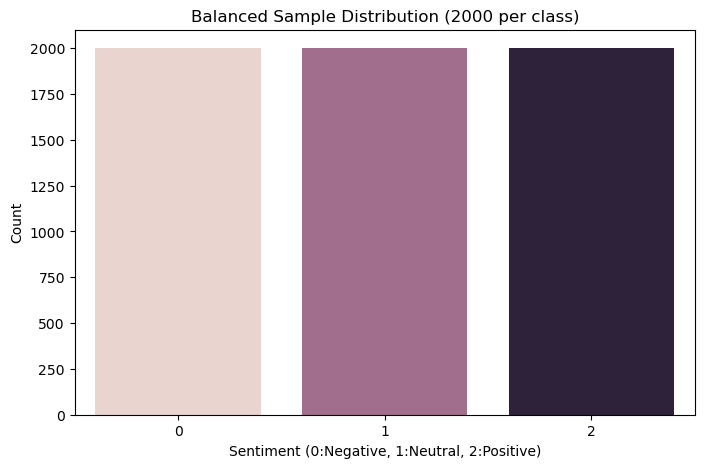

Dataset Overview:
Total number of reviews: 6000

Class Distribution:
sentiment
0    2000
1    2000
2    2000
Name: count, dtype: int64


/var/folders/yf/fm096zz15bqc6vfl0tpmffg80000gn/T/ipykernel_96564/1457213187.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='sentiment', palette='viridis')
/var/folders/yf/fm096zz15bqc6vfl0tpmffg80000gn/T/ipykernel_96564/1457213187.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='sentiment', y='review_length', palette='viridis')
/var/folders/yf/fm096zz15bqc6vfl0tpmffg80000gn/T/ipykernel_96564/1457213187.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='sentiment', y='word_count', palette='viri

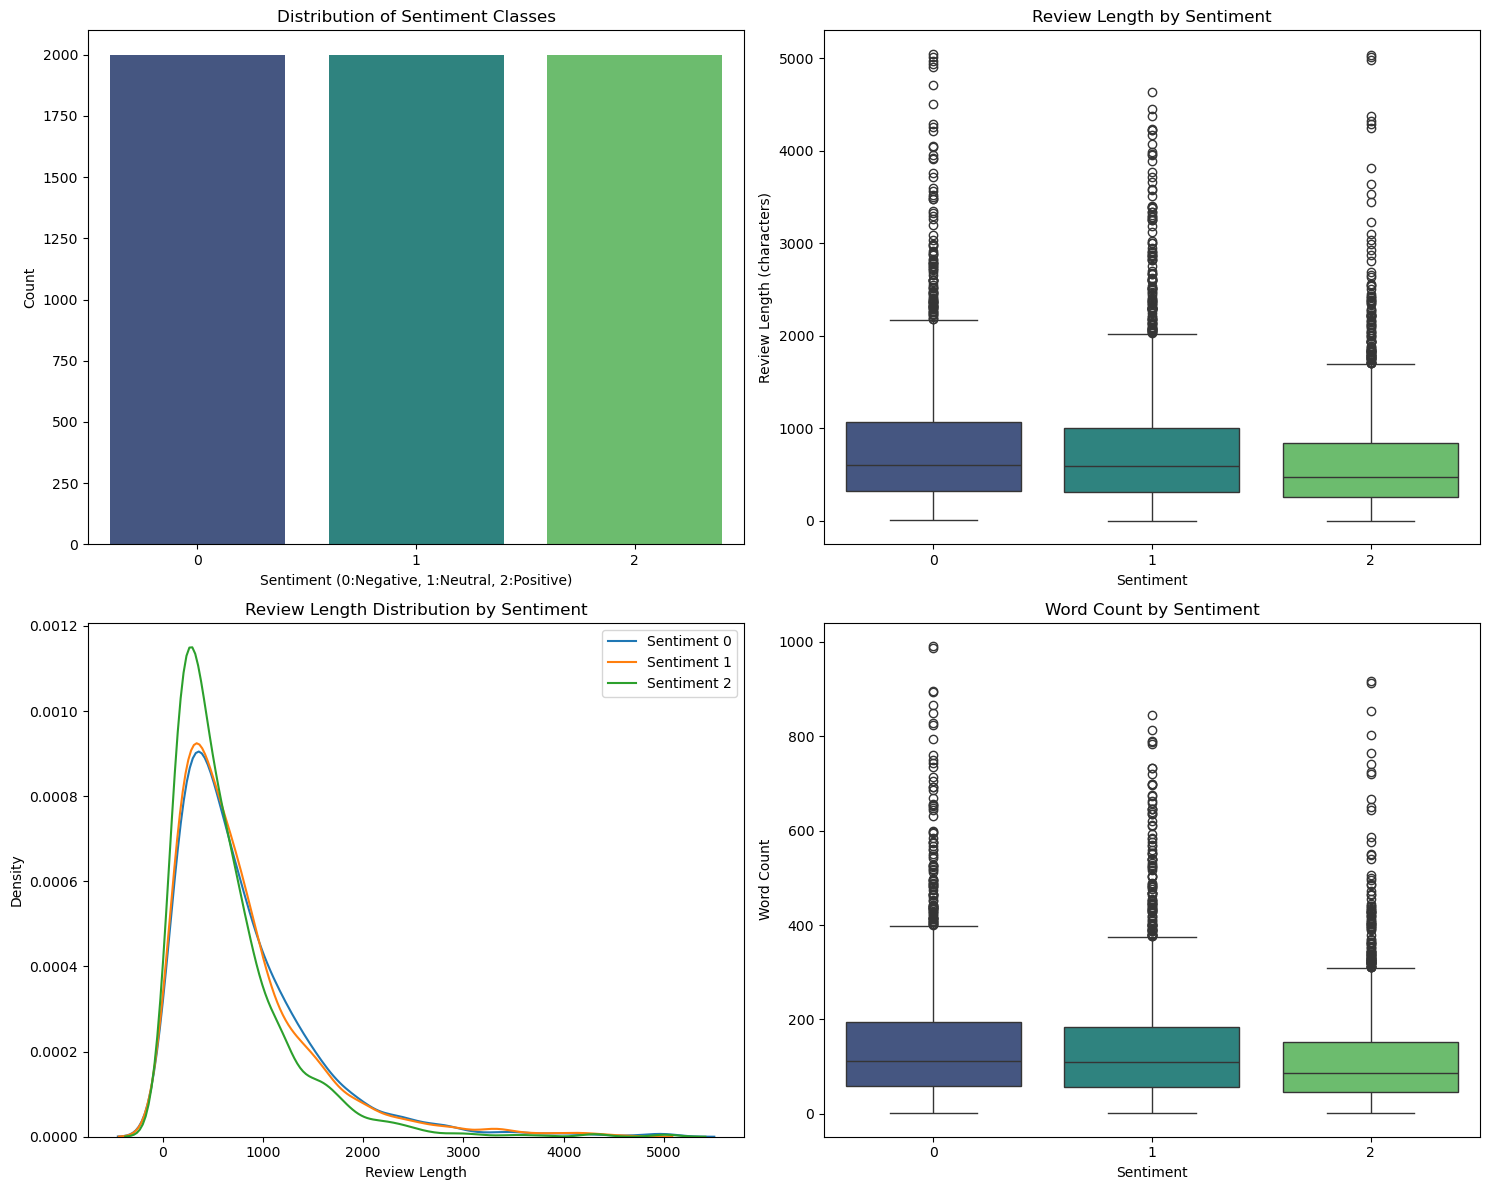


Text Analysis Summary:
Average review length: 737.56 characters
Average word count: 135.14 words

Detailed Statistics by Sentiment:
          review_length                   word_count                 
                   mean     std min   max       mean     std min  max
sentiment                                                            
0                798.09  690.21   5  5050     147.75  128.04   1  991
1                775.02  674.61   4  4641     141.35  122.16   1  846
2                639.59  571.61   1  5039     116.31  103.69   1  917

Special Character Usage:
Percentage of reviews with exclamation marks: 43.78%
Percentage of reviews with question marks: 17.72%
Percentage of reviews with ellipsis: 24.45%


/var/folders/yf/fm096zz15bqc6vfl0tpmffg80000gn/T/ipykernel_96564/1457213187.py:104: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=words_df, x='count', y='word', palette='viridis')
/var/folders/yf/fm096zz15bqc6vfl0tpmffg80000gn/T/ipykernel_96564/1457213187.py:104: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=words_df, x='count', y='word', palette='viridis')
/var/folders/yf/fm096zz15bqc6vfl0tpmffg80000gn/T/ipykernel_96564/1457213187.py:104: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=words_df, x='count', y='word', palette='vi

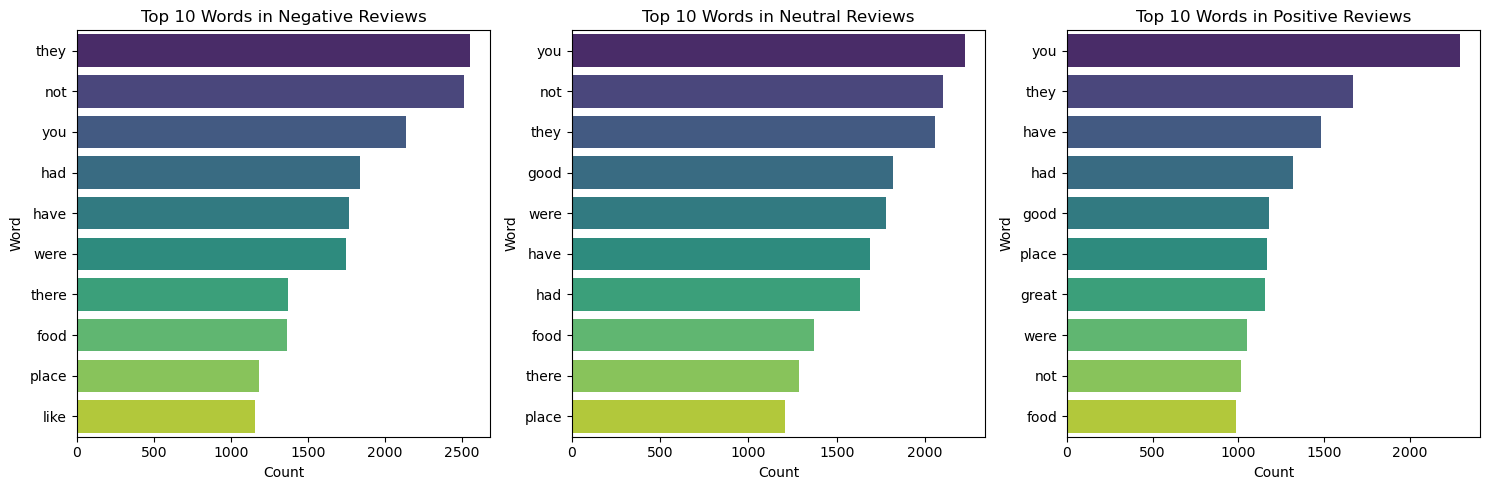

In [15]:
df = create_balanced_sample(dataset, samples_per_class=2000)

# EXPLORE RAW DATA AND VISUALIZATION
explore_data(df)
analyze_common_words(df)

In [16]:
# Split data
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['text'], df['sentiment'],
    test_size=0.1,
    random_state=42,
    stratify=df['sentiment']
)

In [17]:
# Calculate class weights and create model
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
model, tokenizer = create_model_and_tokenizer(class_weights)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


2024-11-25 11:20:53.746073: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


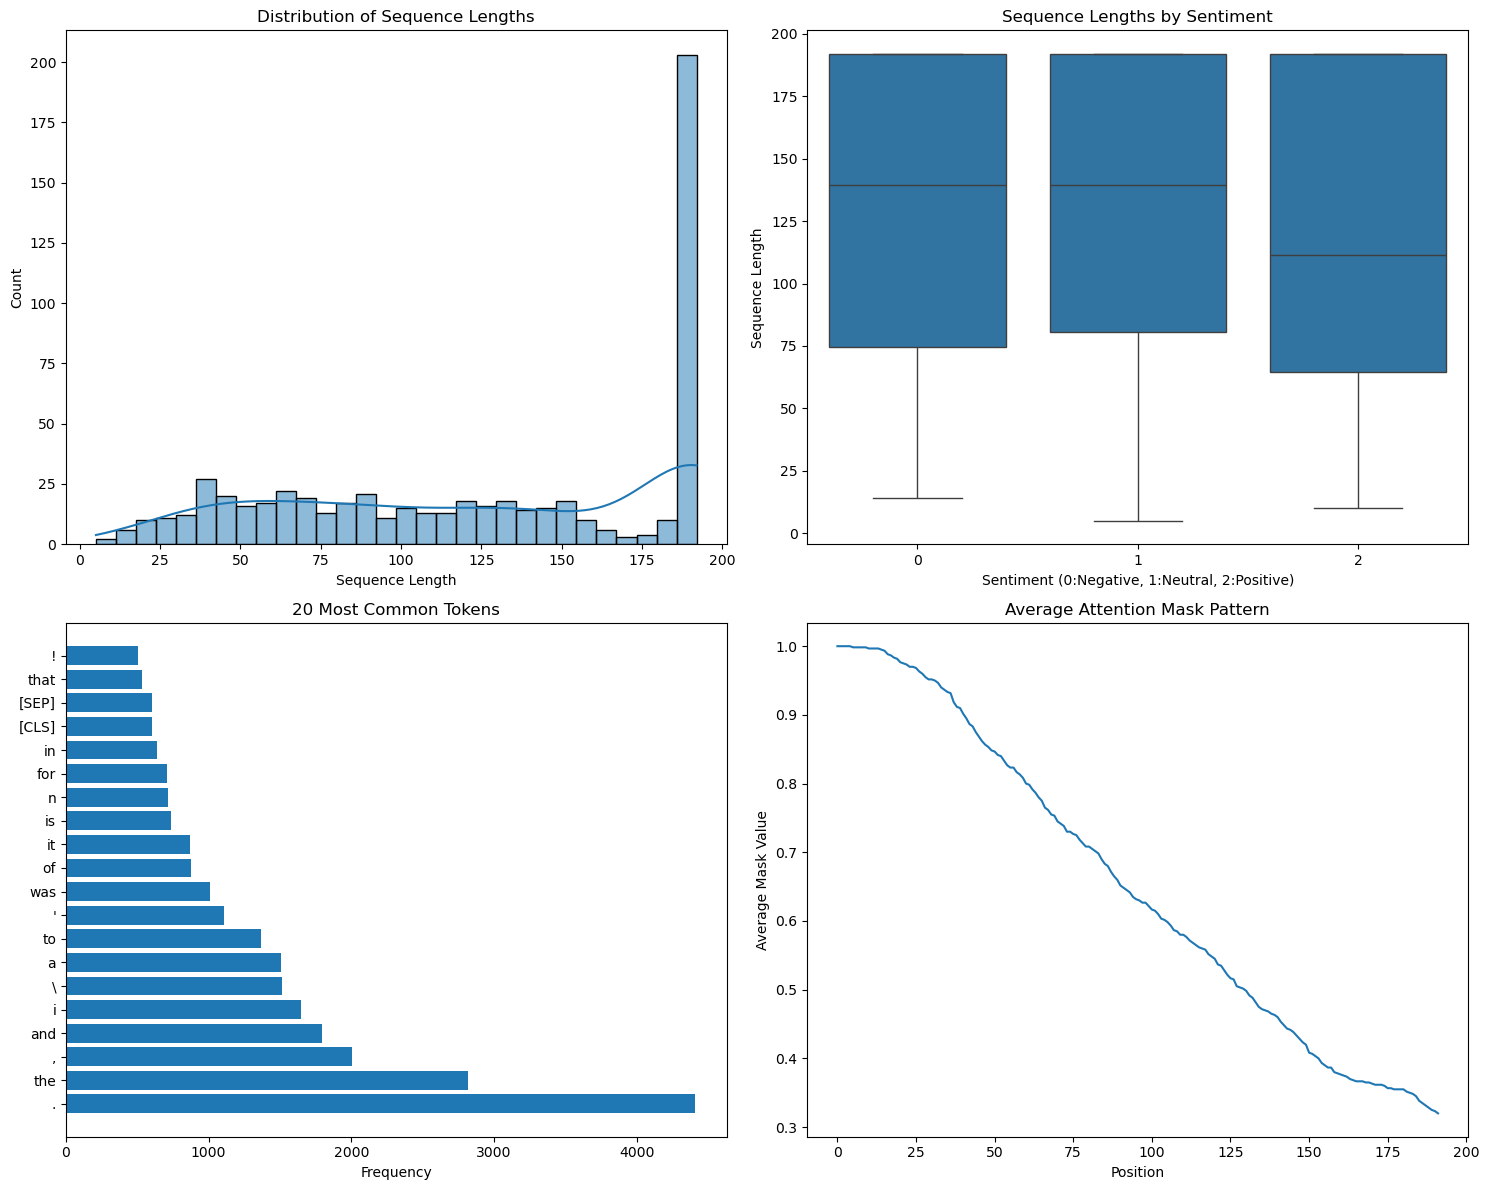


Tokenized Dataset Statistics:
Total number of sequences: 600
Maximum sequence length: 192
Average sequence length: 125.44
Median sequence length: 130.00

Label Distribution:
Sentiment 0: 200 sequences (33.33%)
Sentiment 1: 200 sequences (33.33%)
Sentiment 2: 200 sequences (33.33%)

Special Token Usage:
[UNK]: 0 occurrences
[SEP]: 600 occurrences
[PAD]: 39938 occurrences
[CLS]: 600 occurrences
[MASK]: 0 occurrences
[SARCASM]: 0 occurrences
[NEGATION]: 0 occurrences
[MULTI_SENTIMENT]: 0 occurrences
[HAPPY_EMOJI]: 0 occurrences
[SAD_EMOJI]: 0 occurrences
[SKEPTICAL_EMOJI]: 0 occurrences


2024-11-25 11:20:54.226331: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


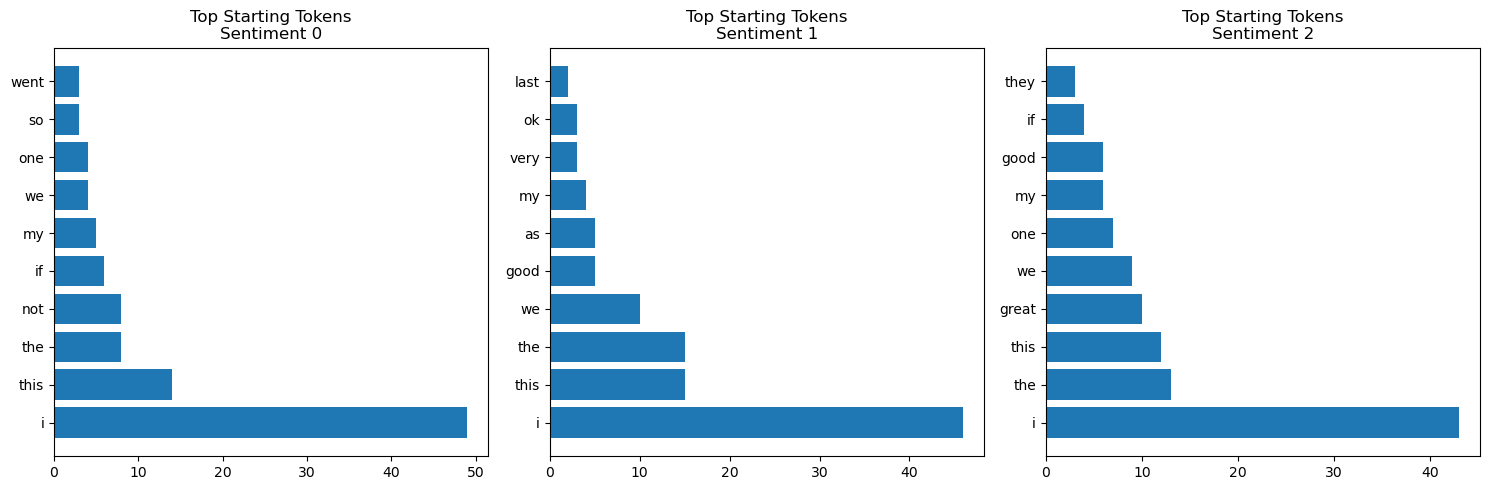


Example Tokenized Sequences by Sentiment:

Sentiment 0:
- [CLS] the bf has been pie obsessed for the last year and while we think we found the best pie shop already, we wanted to give all pies a chance to surprise us. \ n \ ni got excited browsing the extensive menu online and they say they're the best and worth the trip even to summerlin for someone who is on the strip visiting, even. with that kind of bravado to declare yourself best, it at least had to be decent. a place with the word pies in it, how could it go wrong, right? \ n \ nit's a bit out of the way, you have to go into sun city golf course community and it's in their little shopping center. we got a cherry pie, for $ 9. 49 and it's a rather big pie for the price which seemed like a plus, if it was good. \ n \ nunfortunately, this was [SEP]
- [CLS] the only good things about this hotel - casino are that it is cheap and it has a great location on the strip. the rooms were quaint ( meaning really old ). although i requested 

In [18]:
# Prepare datasets
train_dataset = prepare_dataset(train_texts, train_labels, tokenizer)
val_dataset = prepare_dataset(val_texts, val_labels, tokenizer)

explore_tokenized_dataset(val_dataset, tokenizer)
analyze_token_patterns(val_dataset, tokenizer)

In [19]:
# train the model
history = train_model(model, train_dataset, val_dataset)

Epoch 1/5
169/169 [==============================] - 1213s 7s/step - loss: 0.9051 - accuracy: 0.5543 - val_loss: 0.6989 - val_accuracy: 0.7050 - lr: 1.0000e-05
Epoch 2/5
169/169 [==============================] - 1261s 7s/step - loss: 0.6590 - accuracy: 0.7157 - val_loss: 0.6574 - val_accuracy: 0.7233 - lr: 1.0000e-05
Epoch 3/5
169/169 [==============================] - 1219s 7s/step - loss: 0.5579 - accuracy: 0.7680 - val_loss: 0.6095 - val_accuracy: 0.7367 - lr: 1.0000e-05
Epoch 4/5
169/169 [==============================] - 1240s 7s/step - loss: 0.4636 - accuracy: 0.8202 - val_loss: 0.6559 - val_accuracy: 0.7050 - lr: 1.0000e-05
Epoch 5/5
169/169 [==============================] - 1287s 8s/step - loss: 0.3763 - accuracy: 0.8672 - val_loss: 0.6932 - val_accuracy: 0.7400 - lr: 1.0000e-05


In [24]:
import os
import json
import tensorflow as tf
from transformers import DistilBertTokenizer

def save_trained_model(model, tokenizer, save_dir=os.path.expanduser('~/Downloads/model')):
    """
    Save both the model and tokenizer in Downloads folder
    """
    # Create directory if it doesn't exist
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    # Save model weights
    model.save_weights(f'{save_dir}/sentiment_model_weights.h5')
    
    # Save tokenizer
    tokenizer.save_pretrained(save_dir)
    
    print(f"Model saved in: {save_dir}")
    
    # Quick validation
    test_text = ["This was great!", "This was terrible", "It was okay"]
    tokenized = tokenizer(test_text, padding=True, truncation=True, return_tensors='tf')
    predictions = model(tokenized)
    print("Model validation - Output shape:", predictions.shape)

In [25]:
#save the model
save_trained_model(model, tokenizer)

Model saved in: /Users/afshinpaydar/Downloads/model
Model validation - Output shape: (3, 3)


In [26]:
# Test the model
for i, review in enumerate(test_reviews, 1):
   results = analyze_sentiment(model, tokenizer, review)
   print(f"\nReview {i}:")
   print("Text:", review)
   print("Analysis:", results)


Review 1:
Text: I did not enjoy this restaurant at all. The food was cold and service was terrible.
Analysis: {'negative': 0.5529422163963318, 'neutral': 0.22824162244796753, 'positive': 0.2188161313533783, 'has_sarcasm': False, 'has_negation': True, 'is_multipolar': True}

Review 2:
Text: Oh great, waiting 2 hours for cold food is exactly how I wanted to spend my evening. best restaurant ever!!!
Analysis: {'negative': 0.22354930639266968, 'neutral': 0.23577210307121277, 'positive': 0.5406785607337952, 'has_sarcasm': False, 'has_negation': False, 'is_multipolar': True}

Review 3:
Text: The vibe was nice but the food was bad and service was slow. Not sure how to feel about this place.
Analysis: {'negative': 0.48770880699157715, 'neutral': 0.28093087673187256, 'positive': 0.23136037588119507, 'has_sarcasm': True, 'has_negation': False, 'is_multipolar': True}

Review 4:
Text: The food wasn't bad, but it wasn't great either. Just an average experience.
Analysis: {'negative': 0.34273073077

In [27]:
import sys


def load_trained_model(load_dir=os.path.expanduser('~/Downloads/model')):
    """
    Load the saved model and tokenizer
    """
    # Add model directory to Python path
    sys.path.append(load_dir)
    
    # Import the model architecture
    from model_architecture import EnhancedDistilBertForSentiment
    
    # Initialize model
    model = EnhancedDistilBertForSentiment()
    
    # Load weights
    model.load_weights(os.path.join(load_dir, 'sentiment_model_weights.h5'))
    
    # Load tokenizer
    tokenizer = DistilBertTokenizer.from_pretrained(load_dir)
    
    return model, tokenizer

In [29]:
import os

def save_model_code(save_dir=os.path.expanduser('~/Downloads/model')):
    """
    Save the model class definition to a Python file
    """
    # Your exact model code
    model_code = '''
import tensorflow as tf
from transformers import TFDistilBertModel, DistilBertTokenizer

class EnhancedDistilBertForSentiment(tf.keras.Model):
    def __init__(self, num_classes=3):
        super().__init__()
        
        # Load DistilBERT
        self.distilbert = TFDistilBertModel.from_pretrained('distilbert-base-uncased')
        
        # Adjusted LSTM units based on average text length
        lstm_units = 156  # Slightly larger than average word count
        
        # Bidirectional LSTM with adjusted units
        self.lstm = tf.keras.layers.Bidirectional(
            tf.keras.layers.LSTM(lstm_units, return_sequences=True)
        )
        
        # Updated attention dimensions
        attention_dim = 96  # Increased for better feature capture
        self.attention_query = tf.keras.layers.Dense(attention_dim)
        self.attention_key = tf.keras.layers.Dense(attention_dim)
        self.attention_value = tf.keras.layers.Dense(attention_dim)
        
        # Adjusted fusion layers
        self.fusion_dense1 = tf.keras.layers.Dense(320, activation='relu')  # Increased width
        self.fusion_dense2 = tf.keras.layers.Dense(160, activation='relu')
        
        # Adjusted dropout rate based on text length variability
        self.dropout1 = tf.keras.layers.Dropout(0.25)  # Before fusion
        self.dropout2 = tf.keras.layers.Dropout(0.35)  # After fusion
        
        # Output layer
        self.classifier = tf.keras.layers.Dense(num_classes, activation='softmax')

    def attention(self, query, key, value, training=False):
        attention_weights = tf.matmul(query, key, transpose_b=True)
        attention_weights = tf.nn.softmax(attention_weights, axis=-1)
        attended_values = tf.matmul(attention_weights, value)
        return attended_values

    def call(self, inputs, training=False):
        # Get DistilBERT embeddings
        distilbert_outputs = self.distilbert(inputs['input_ids'],
                                          attention_mask=inputs['attention_mask'],
                                          training=training)
        sequence_output = distilbert_outputs[0]
        
        # Process sequence with LSTM
        lstm_output = self.lstm(sequence_output)
        
        # Apply first dropout
        lstm_output = self.dropout1(lstm_output, training=training)
        
        # Self-attention
        query = self.attention_query(lstm_output)
        key = self.attention_key(lstm_output)
        value = self.attention_value(lstm_output)
        attention_output = self.attention(query, key, value, training)
        
        # Global pooling with attention weights
        pooled = tf.reduce_mean(attention_output, axis=1)
        
        # Feature fusion with dropouts
        fused = self.fusion_dense1(pooled)
        fused = self.fusion_dense2(fused)
        dropped = self.dropout2(fused, training=training)
        
        # Final classification
        outputs = self.classifier(dropped)
        return outputs
'''
    
    # Save to a .py file
    with open(os.path.join(save_dir, 'model_architecture.py'), 'w') as f:
        f.write(model_code)
    
    print(f"Model architecture saved to: {save_dir}/model_architecture.py")

# Save the architecture
save_model_code()

Model architecture saved to: /Users/afshinpaydar/Downloads/model/model_architecture.py
